# Initial Trading Strategy Breakdown

## 1. Introduction

The basis of our initial trading strategy is to use the signals, which we have determined indicate a future directional change in the market based on whether the number is positive or negative. Positive signals forecast a positive return the following day and vice versa. The magnitude of the signal also indicates our confidence level; the further the number is from zero, the larger the expected returns.

# The problem we are solving, how we approached the problem.

The strategy we are setting out to create will predict the next day's movement by determining if we should buy, sell, or stay away. The next day's movement is determined by the equity returns column, which we created during data preprocessing. Since we do not interact with this column during testing, we avoid look-forward bias. This allows us to validate the strategy without the need for setting up a complex backtesting environment. The strategy will determine, based on the signal, if the trade signal column (which defaults to 0) will have a -1 (Sell) or a 1 (Buy). We then calculate a strategy returns column by multiplying our trade_signal by the equity returns column to determine the final value for that specific signal. This simplifies the problem and our solution, allowing us to focus acutely on the signal and our understanding of it to generate our trade signal, which is easy to test and quantify.

## 2. Hypothesis

Our hypothesis is that by categorizing signals into quantiles, we can identify specific ranges of signals that consistently predict positive or negative returns. By focusing on these ranges, we can create a trading strategy that outperforms a baseline strategy that trades every signal.

### Some Questions to Answer

#### Why are we using quantiles along with standard deviation and not just trade everything above or below one standard deviation?

Our strategy essentially does this because we use standard deviation to mark a cut-off in the quantiles. The benefit of using quantiles is that it allows us to magnify the data even more and may present us with easy optimizations. One optimization we will evaluate further is betting larger for the 0 and 9 quantiles, which statistically have much higher returns than all other quantiles. This could be extremely valuable, especially when taking into account trading fees, as we would be able to focus on higher expectancy bets.

#### Why we believe the relationship will carry over from our training data to our testing data

The distribution graphing identified a bell curve shape for both data sets. This gives us a fair amount of confidence that, given a sufficient amount of data in both the training and testing data sets, we can expect the distributions of the signal to be relatively similar. 

#### Trading Fees !!!

Trading fees need to be accounted for for several reasons. Firstly, it would be unreasonable to expect to trade with no fees, as only the largest tiers of traders have no fees, which would most likely be market-making fees, limiting our strategy to only passive fills. Secondly, it benefits our trading strategy, which is more selective than the baseline strategy we will be using for comparison, which is not selective and trades every signal.

 - Trading fee's can really impact the strategy and the overall performance relative to the baseline strategy which trades every signal, it also could determine if we want to be even more selective about the strategy we are using. 



## Steps to implement the strategy

We begin by loading the processed data from the CSV file. The data is then split into training and testing sets to evaluate the performance of our strategy.
We also include a baseline testing data set that is an untouched test dataset that we will use for testing the baseline strategy for comparison. As we mentioned before this strategy will trade every singal. 

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

processed_file_path = "../data/processed/processed_data.csv"
data = pd.read_csv(processed_file_path)

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
base_line_test_data_raw = test_data.copy()


### Create a baseline test data set

We will use this as the benchmark to compare our more selective strategy to a strategy that trades every signal.
- The below method:     
    Assigns baseline trading signals based on the signal value.
    - If signal > 0, trade_signal = -1 (sell)
    - If signal < 0, trade_signal = 1 (buy)

It then structures the data in a similar fashion to our trading strategy test data so that we can use the same strategy returns calculator.
- This can be helpful in preventing data consistancy/code consistancy issues as both strategies are using the same returns calculator to generate returns statistics.

In [183]:
def assign_baseline_test_data_trade_signal(data):
    data['trade_signal'] = np.where(data['signal'] < 0, -1, 1)
    return data

In [184]:
base_line_test_data = assign_baseline_test_data_trade_signal(base_line_test_data_raw)
print("Base_line_test_data:")
print(base_line_test_data.head(5))
print(base_line_test_data.tail(5))

Base_line_test_data:
       Unnamed: 0    signal  equity_curve  equity_returns  trade_signal
39996       39997 -0.019529      0.399808        0.008007            -1
39997       39998 -0.002748      0.403009        0.003799            -1
39998       39999  0.003560      0.404540       -0.006057             1
39999       40000 -0.004265      0.402090        0.001539            -1
40000       40001 -0.005516      0.402709       -0.010325            -1
       Unnamed: 0    signal  equity_curve  equity_returns  trade_signal
49991       49992  0.008869      0.454290       -0.010942             1
49992       49993 -0.009403      0.449320        0.002981            -1
49993       49994 -0.005492      0.450659       -0.008348            -1
49994       49995  0.009746      0.446897       -0.004429             1
49995       49996 -0.017378      0.444918        0.001619            -1


### Perform Quantile Analysis

We perform quantile analysis on the training data to categorize the signals. This allows us to identify specific ranges of signals that are more likely to result in positive or negative returns. We also determine the standard deviation of our positive and negative signals to use as cut-off points for which quantiles we will allow to use as trading signals.

To facilitate the assignment of trading signals, we create bins using numpy. These bins will be used in a method to assign trading signals to our dataset. To account for signal values that exceed the maximum or minimum values in our dataset, our bins include -inf and +inf as the minimum and maximum boundaries, respectively.



In [185]:
train_data['signal_quantile'] = pd.qcut(train_data['signal'], 10, labels=False)
quantile_summary = train_data.groupby('signal_quantile')['signal'].agg(['min', 'max']).reset_index()

bins = [-np.inf] + quantile_summary['max'].tolist() + [np.inf]
print("Bins:")
print(bins)

print("Quantile Summary:")
print(quantile_summary)

positive_signals_std = train_data[train_data['signal'] > 0]['signal'].std()
negative_signals_std = train_data[train_data['signal'] < 0]['signal'].std()

buy_quantiles = quantile_summary[quantile_summary['max'] >= positive_signals_std]['signal_quantile'].tolist()
sell_quantiles = quantile_summary[quantile_summary['min'] <= -negative_signals_std]['signal_quantile'].tolist()

print(f"Buy quantiles: {buy_quantiles}")
print(f"Sell quantiles: {sell_quantiles}")

Bins:
[-inf, -0.0126631170999312, -0.008347696736757, -0.0053141359849129, -0.0026471630860451, -0.0001825653480221, 0.0022790556731195, 0.0049271373250957, 0.0080094999625867, 0.0123688183831138, 0.0372032712589485, inf]
Quantile Summary:
   signal_quantile       min       max
0                0 -0.041569 -0.012663
1                1 -0.012659 -0.008348
2                2 -0.008346 -0.005314
3                3 -0.005312 -0.002647
4                4 -0.002647 -0.000183
5                5 -0.000182  0.002279
6                6  0.002279  0.004927
7                7  0.004927  0.008009
8                8  0.008010  0.012369
9                9  0.012370  0.037203
Buy quantiles: [7, 8, 9]
Sell quantiles: [0, 1, 2]


## Assigning Trading Signals and Analyzing Results

In this block of code, we define a function assign_trading_signals to assign trading signals to our dataset based on predefined quantile bins. We then apply this function to our test data, calculate cumulative returns, and generate a summary of the results.

In [186]:
def assign_trading_signals(data, bins, buy_quantiles, sell_quantiles):
    data['signal_quantile'] = pd.cut(data['signal'], bins=bins, labels=False, include_lowest=True)
    
    data['trade_signal'] = 0

    data.loc[data['signal_quantile'].isin(buy_quantiles), 'trade_signal'] = 1
    data.loc[data['signal_quantile'].isin(sell_quantiles), 'trade_signal'] = -1

    return data

In [187]:

test_data_with_signals = assign_trading_signals(test_data, bins, buy_quantiles, sell_quantiles)

test_data_with_signals['cumulative_returns'] = test_data_with_signals.groupby('signal_quantile')['equity_returns'].cumsum()

test_group_summary = test_data_with_signals.groupby('signal_quantile').agg({
    'signal': ['min', 'max', 'mean'],
    'equity_returns': ['mean', 'median', 'min', 'max', 'std', 'count'],
    'cumulative_returns': ['last']
}).reset_index()

print("Test Group Summary by Signal Quantile:")
print(test_group_summary)

Test Group Summary by Signal Quantile:
  signal_quantile    signal                     equity_returns            \
                        min       max      mean           mean    median   
0               0 -0.035731 -0.012667 -0.017365      -0.000276 -0.000152   
1               1 -0.012645 -0.008350 -0.010320      -0.000689 -0.000655   
2               2 -0.008335 -0.005315 -0.006783      -0.000251 -0.000438   
3               3 -0.005311 -0.002648 -0.003941       0.000272  0.000080   
4               4 -0.002642 -0.000185 -0.001438       0.000006  0.000164   
5               5 -0.000182  0.002275  0.001038       0.000162 -0.000297   
6               6  0.002286  0.004921  0.003572      -0.000062 -0.000319   
7               7  0.004943  0.008006  0.006427       0.000562  0.000080   
8               8  0.008012  0.012358  0.010030       0.000702  0.000718   
9               9  0.012370  0.035097  0.016928       0.000187  0.000448   

                                      cumulative

### Analysis

Note on Lower Quartiles: Negative returns in lower quartiles (0 to 2) where we are selling are actually considered positive since the strategy benefits from negative equity returns.

1. **Winning Quantiles**:
   - **Quartiles 0 and 9**: These quartiles are positive, indicating that the strategy is profitable even at the extreme ends of the signal values.
   - **Quartiles 1 and 8**: These quartiles have shown significant returns, indicating a high degree of predictability in these ranges.
   - **Quartiles 2 and 7**: These quartiles are also showing strong returns, consistent with our hypothesis. 
   - **Quartiles 3 through 6**: We see an increase in standard deviation of returns in these quartiles and some variability in returns, quartile 3 and 6 are actually losing relatively signficantly.
    
2. **Performance Distribution**:
   - The returns are positive across all trading quartiles, which validates our hypothesis that certain signal ranges can consistently predict market movements.
   - Quartile 1 has the highest negative cumulative returns, which deviates from our intial thought that the largest magnitude quartiles would perform the best. This gives us a great opportunity to investigate further. 

3. **Standard Deviation and Count**:
   - The standard deviation of returns within each quantile is fairly consistent, indicating stable performance across different signal ranges.
   - The count of observations in each quantile is fairly uniform, ensuring that our analysis is based on a representative sample.

### Interpretation 

- The results validate our initial hypothesis that specific signal ranges (quantiles) can predict market movements.
- The strategy performs well across all of our trading quantiles, specifically avoiding the quantiles which have either negative returns or higher standard deviation of returns.
- We might consider further optimization, such as adjusting trade sizes for different quantiles based on their performance or exploring why certain quantiles perform better.


# Comparing Our Strategy to Our Baseline Strategy
In this section, we compare the performance of our selective trading strategy against a baseline strategy that trades every signal. We calculate key trading statistics for each strategy, including total return, volatility, Sharpe ratio, and maximum drawdown.

### Selective Strategy Statistics
- **Total Return**: Indicates the overall return of the strategy over the testing period.
- **Volatility**: Measures the risk or variability of returns.
- **Sharpe Ratio**: Indicates risk-adjusted return. A higher Sharpe ratio is better.
- **Max Drawdown**: The largest peak-to-trough decline in the strategy's equity curve.
- **Total Trades**: The amount of times the strategy is trading, this is important for comparing the selective strategy to the baseline strategy which always trades.
- **Win Percentage**: The amount the strategy is winning, value is important because when it comes to optimization this statistics stands out as the most glaring place to try and optimize

By comparing these statistics, we can determine whether our selective trading strategy offers superior performance compared to the baseline strategy that trades every signal.
This is essentially the ask of the problem, to improve on a system that selects every signal.

For our initial simulation we are using a trading fee 0.0005, this is going to be extremely crippling to the less selective strategy but we will also run a simulation with a .0002 trading fee and it will demonstrate that even with reduced trading fees initial selective strategy perform quite well.

In [188]:

def calculate_strategy_returns(data, fee):
    trading_fee = fee
    data['strategy_returns'] = data['equity_returns'] * data['trade_signal']
    data['trading_fee'] = abs(data['trade_signal']) * data['equity_curve'] * (-trading_fee)
    data['strategy_returns'] += data['trading_fee']
    data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod() - 1
    return data

def calculate_trading_statistics(data):
    frequency=252*6.5*60
    total_return = data['cumulative_strategy_returns'].iloc[-1]
    daily_returns = data['strategy_returns']
    volatility = daily_returns.std() * np.sqrt(frequency)
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(frequency)
    drawdown = 1 - ((1 + data['cumulative_strategy_returns']).div((1 + data['cumulative_strategy_returns']).cummax()))
    max_drawdown = drawdown.max()
    total_trades = data['trade_signal'].abs().sum()
    winning_trades = data[data['strategy_returns'] > 0]['trade_signal'].abs().sum()
    win_percentage = winning_trades / total_trades * 100

    return {
        "Total Return": total_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Total Trades": total_trades,
        "Win Percentage": win_percentage
    }

Selective Strategy Statistics:
Total Return: 1.61
Volatility: 2.45
Sharpe Ratio: 5.08
Max Drawdown: 0.44
Total Trades: 6020.00
Win Percentage: 50.60

Baseline Strategy Statistics:
Total Return: -0.15
Volatility: 3.14
Sharpe Ratio: 1.04
Max Drawdown: 0.75
Total Trades: 10000.00
Win Percentage: 49.80


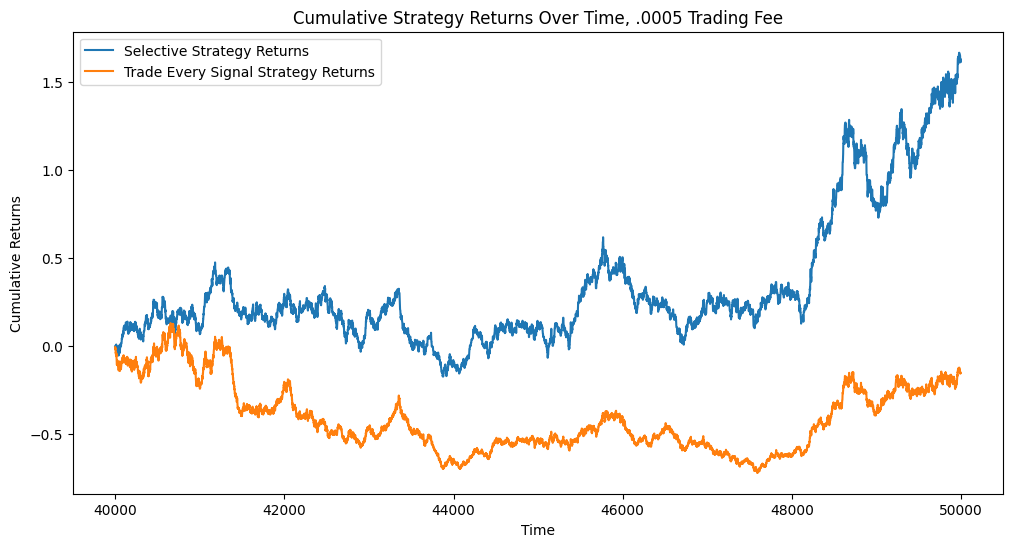

In [189]:

test_data_with_returns = calculate_strategy_returns(test_data_with_signals, .0005)
test_data_with_baseline_returns = calculate_strategy_returns(base_line_test_data, .0005)

selective_stats = calculate_trading_statistics(test_data_with_returns)
baseline_stats = calculate_trading_statistics(test_data_with_baseline_returns)

print("Selective Strategy Statistics:")
for key, value in selective_stats.items():
    print(f"{key}: {value:.2f}")
  
print("\nBaseline Strategy Statistics:")
for key, value in baseline_stats.items():
    print(f"{key}: {value:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(test_data_with_returns['cumulative_strategy_returns'], label='Selective Strategy Returns')
plt.plot(test_data_with_baseline_returns['cumulative_strategy_returns'], label='Trade Every Signal Strategy Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Strategy Returns Over Time, .0005 Trading Fee')
plt.legend()
plt.show()

## Analyzing Our Initial Trading Statistics in Comparison to Our Benchmark of Trading Every Signal

**1. Total Return**:

The selective strategy yielded a total return of 1.61, significantly outperforming the baseline strategy, which resulted in a negative return of -0.15. This demonstrates the effectiveness of our selective approach in generating positive returns.

**2. Volatility**:

The selective strategy exhibited lower volatility (2.45) compared to the baseline strategy (3.14). Lower volatility indicates a more stable performance and reduced risk, highlighting the robustness of the selective strategy.

**3. Sharpe Ratio**:

The Sharpe Ratio of the selective strategy (5.08) is substantially higher than that of the baseline strategy (1.04). A higher Sharpe Ratio indicates better risk-adjusted returns, underscoring the efficiency of our selective trading approach.

**4. Max Drawdown**:

The max drawdown for the selective strategy (0.44) is considerably lower than that of the baseline strategy (0.75). This indicates that the selective strategy is more resilient to significant losses, ensuring better capital preservation.

# Conclusion 

The selective trading strategy significantly outperforms the baseline strategy across multiple performance metrics, including total return, volatility, Sharpe Ratio, and max drawdown. It should be noted that the trading fees were signficantly crippling for both strategies which drastically outperform the market with reduced fees. However, the selectiveness of the selective trading strategy allows it to turn a substantial profit even with increased trading fees.

### Additional Notes

**1. Scalability**: The selected strategy also works if the sample size is increased, actually further improving the strategy the more data is included in the test data set.

**2. Dynamic Quantiles**: Since the quantiles are dynamic, they adjust based on the values in the test database.

**3. Stability**: Due to the bell curve nature of the data, the quantiles shouldn't adjust too much by changing the dataset as long as there is sufficient data to use.

**4. Fee Sensitivity**: Below are two more graphs of return of the same strategy with fees at .0002 and also no fees. As you can see, the selective strategy outperforms the baseline strategy in all cases

# Below Is the Comparison Of The Other Fee Structures


#### This shows the returns if a .0002 fee is used

Selective Strategy Statistics:
Total Return: 5.06
Volatility: 2.45
Sharpe Ratio: 8.46
Max Drawdown: 0.34
Total Trades: 6020.00
Win Percentage: 51.16

Baseline Strategy Statistics:
Total Return: 2.42
Volatility: 3.14
Sharpe Ratio: 5.42
Max Drawdown: 0.58
Total Trades: 10000.00
Win Percentage: 50.38


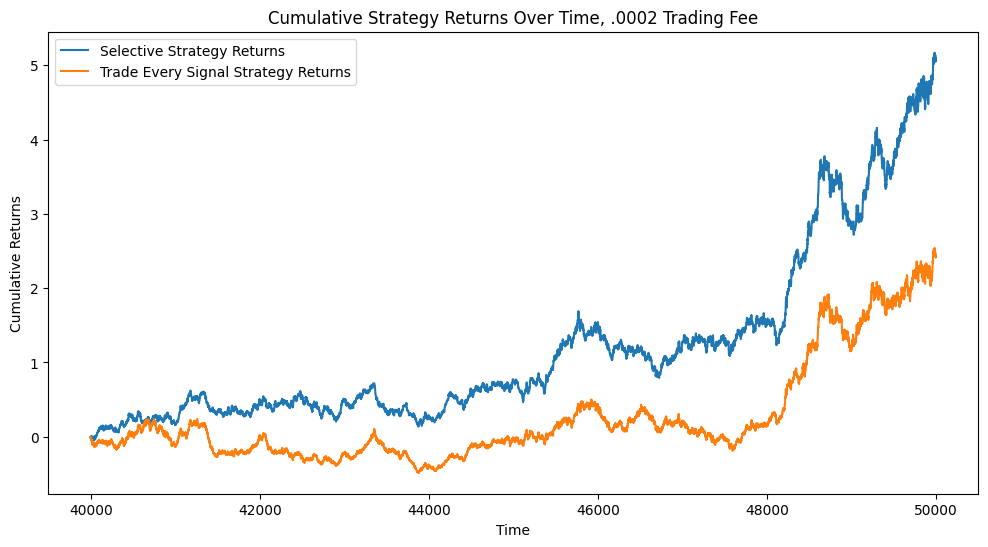

In [190]:

test_data_with_returns_low_fee = calculate_strategy_returns(test_data_with_signals, .0002)
test_data_with_baseline_returns_low_fee  = calculate_strategy_returns(base_line_test_data, .0002)

selective_stats_low_fee = calculate_trading_statistics(test_data_with_returns_low_fee)
baseline_stats_low_fee = calculate_trading_statistics(test_data_with_baseline_returns_low_fee)

print("Selective Strategy Statistics:")
for key, value in selective_stats_low_fee.items():
    print(f"{key}: {value:.2f}")
  
print("\nBaseline Strategy Statistics:")
for key, value in baseline_stats_low_fee.items():
    print(f"{key}: {value:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(test_data_with_returns_low_fee['cumulative_strategy_returns'], label='Selective Strategy Returns')
plt.plot(test_data_with_baseline_returns_low_fee['cumulative_strategy_returns'], label='Trade Every Signal Strategy Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Strategy Returns Over Time, .0002 Trading Fee')
plt.legend()
plt.show()

#### This shows the returns if no fee is used

Selective Strategy Statistics:
Total Return: 9.61
Volatility: 2.45
Sharpe Ratio: 10.71
Max Drawdown: 0.31
Total Trades: 6020.00
Win Percentage: 51.50

Baseline Strategy Statistics:
Total Return: 7.68
Volatility: 3.14
Sharpe Ratio: 8.34
Max Drawdown: 0.50
Total Trades: 10000.00
Win Percentage: 50.71


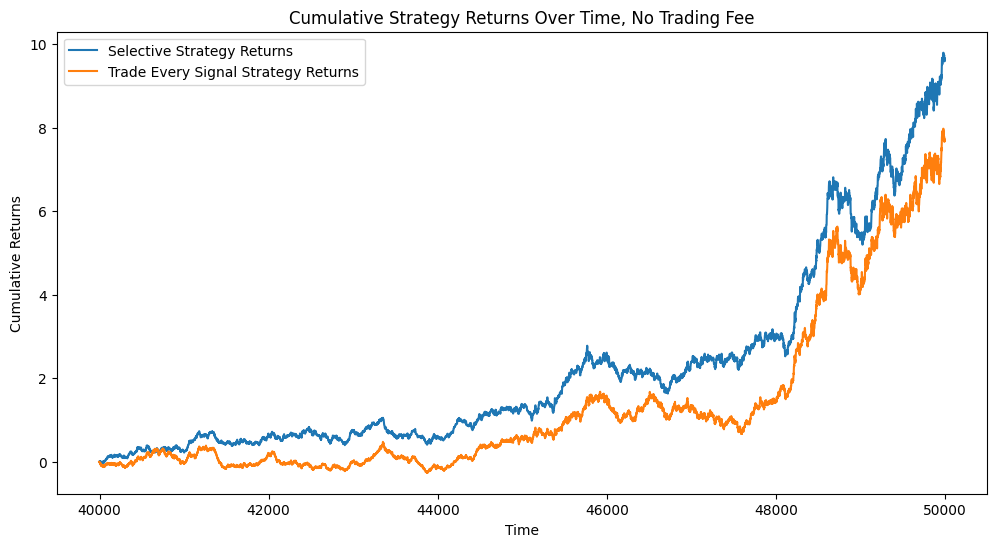

In [191]:

test_data_with_returns_no_fee = calculate_strategy_returns(test_data_with_signals, .0)
test_data_with_baseline_returns_no_fee  = calculate_strategy_returns(base_line_test_data, 0)

selective_stats_no_fee = calculate_trading_statistics(test_data_with_returns_no_fee)
baseline_stats_no_fee = calculate_trading_statistics(test_data_with_baseline_returns_no_fee)

print("Selective Strategy Statistics:")
for key, value in selective_stats_no_fee.items():
    print(f"{key}: {value:.2f}")
  
print("\nBaseline Strategy Statistics:")
for key, value in baseline_stats_no_fee.items():
    print(f"{key}: {value:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(test_data_with_returns_no_fee['cumulative_strategy_returns'], label='Selective Strategy Returns')
plt.plot(test_data_with_baseline_returns_no_fee['cumulative_strategy_returns'], label='Trade Every Signal Strategy Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Strategy Returns Over Time, No Trading Fee')
plt.legend()
plt.show()